In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
from matplotlib import pyplot as plt
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from conf import settings
from utils import get_network, get_test_dataloader
from models.resnet import resnet18

In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [3]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.decomposition import PCA
import numpy as np

## Set up data

In [5]:
baseline_missed = set(np.loadtxt('../baseline_wrong.txt'))
approach3_missed = set(np.loadtxt('../approach3_wrong.txt'))
print('baseline missed: {} | approach 3 missed: {}'.format(len(baseline_missed), len(approach3_missed)))
approach3_desired = baseline_missed - approach3_missed

baseline missed: 2466 | approach 3 missed: 2305


In [6]:
id2label = {}
with open('/nethome/bdevnani3/raid/pytorch-cifar100/id2label.txt', 'r') as handle:
    for idx, line in enumerate(handle):
        if idx % 2 == 0:
            element, label = line.strip().split(': ')
            id2label[int(element)] = label
len(id2label)

100

In [7]:
cifar100_test_loader = get_test_dataloader(
    settings.CIFAR100_TRAIN_MEAN,
    settings.CIFAR100_TRAIN_STD,
    #settings.CIFAR100_PATH,
    num_workers=6,
    batch_size=1,
    shuffle=False
    )

Files already downloaded and verified


## Instantiate model

In [8]:
from utils import get_network, get_training_dataloader, get_test_dataloader, WarmUpLR, \
    most_recent_folder, most_recent_weights, last_epoch, best_acc_weights, read_yaml, \
    save_yaml, name_model

# Getting configs

variant_config = read_yaml("/srv/share4/gstoica3/checkpoints/resnet18/self_attention/CSAM_Approachself_attention_BN_PosEmb10_AfterConv(3, 1, 1)_Temp1_StochStrideFalse_Stride1_ResidualTrue/Sunday_13_February_2022_18h_20m_11s/convattn.yaml")


In [9]:
from models.csam import ConvAttnWrapper

In [10]:
net = resnet18()

model = ConvAttnWrapper(backbone=net, variant_kwargs=variant_config).to('cuda:0')

{'apply_stochastic_stride': False, 'approach_name': 'self_attention', 'injection_info': [[3, 1, 1]], 'padding': 'same', 'pos_emb_dim': 10, 'softmax_temp': 1, 'stride': 1, 'suffix': None, 'use_residual_connection': True}


../models/csam.py:251: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  self.local_indices[conv_idx] = input_mask[conv_idx].reshape(-1).nonzero().sort()[0].reshape(-1)


In [11]:
path = '/srv/share4/gstoica3/checkpoints/resnet18/self_attention/CSAM_Approachself_attention_BN_PosEmb10_AfterConv(3, 1, 1)_Temp1_StochStrideFalse_Stride1_ResidualTrue/Sunday_13_February_2022_18h_20m_11s/resnet18-175-best.pth'


In [12]:
weights = torch.load(path)
net_params = {i[0]:i[1] for i in model.named_parameters()}

In [13]:
model.load_state_dict(weights)

<All keys matched successfully>

In [14]:
model.eval()

ConvAttnWrapper(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2_x): Sequential(
      (0): BasicBlock(
        (residual_function): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (residual_function): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1

In [15]:
desired_images = []
desired_labels = []
wrong_images = []
wrong_labels = []
desired_flag = False
wrong_flag = False
desired_data = 64
for n_iter, (image, label) in tqdm(enumerate(cifar100_test_loader)):
    image = image.cuda()
    if n_iter in approach3_desired and not desired_flag:
        desired_images.append(image)
        desired_labels.append(label)
    if n_iter in approach3_missed and not wrong_flag:
        wrong_images.append(image)
        wrong_labels.append(label)
    if len(desired_images) >= desired_data:
        desired_flag = True
    if len(wrong_images) >= desired_data:
        wrong_flag = True
    if desired_flag and wrong_flag: break

682it [00:00, 1105.49it/s]


In [16]:
desired_images = torch.cat(desired_images)
desired_labels = torch.cat(desired_labels)
wrong_images = torch.cat(wrong_images)
wrong_labels = torch.cat(wrong_labels)

In [17]:
predictions = model(wrong_images)

In [18]:
predictions = predictions.argmax(-1).detach().cpu().numpy()

In [19]:
output = wrong_images
inject_layer, inject_number, filter_size = model.variant_kwargs['injection_info'][0]
for layer in tqdm(model.network_structure[:inject_layer]):
    output = layer(output)

100%|██████████| 3/3 [00:00<00:00, 1253.53it/s]


In [20]:
output.shape

torch.Size([64, 128, 16, 16])

In [21]:
import math 

csam = model.network_structure[inject_layer]


batch = output.permute(0, 2, 3, 1)
batch_pos = csam.maybe_add_positional_encodings(batch)
queries = csam.query_transform(batch_pos).flatten(1, 2)
values = csam.value_transform(batch_pos).flatten(1, 2)
keys = csam.key_transform(batch_pos).flatten(1, 2)
score = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(queries.shape[-1])                                 # [B,HW,C] x [B,C,HW] -> [B,HW,HW]
attn = F.softmax(score, -1)                                                                                     # [B,HW,HW]
context = torch.bmm(attn, values) 
context = context.reshape(batch_pos.shape)
print(context.shape)                            

torch.Size([64, 16, 16, 128])


# Visualization Script

In [22]:
idx = 10
batch_pca = PCA(n_components=3)
csam_pca = PCA(n_components=3)

batch_pca.fit(batch[idx].reshape(256, 128).detach().cpu().numpy())
batch_pca.fit(context[idx].reshape(256, 128).detach().cpu().numpy())
print('Batch Explained Variance: {}'.format(batch_pca.explained_variance_ratio_))
# print('CSAM Explained Variance: {}'.format(csam_pca.explained_variance_ratio_))

Batch Explained Variance: [0.72463113 0.21432775 0.03790703]


In [23]:
batch_reduced = batch_pca.transform(batch[idx].reshape(256, 128).detach().cpu().numpy()).reshape(16, 16, 3)
csam_reduced = batch_pca.transform(context[idx].reshape(256, 128).detach().cpu().numpy()).reshape(16, 16, 3)

# Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shark
dolphin


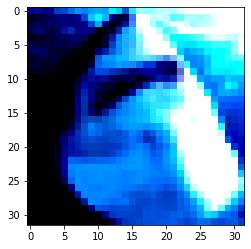

In [24]:
class_name = id2label[wrong_labels[idx].numpy().tolist()]
print(class_name)
print(id2label[predictions[idx]])
image = wrong_images[idx].permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(image)

# Visualization of SA Input from Vision Backbone

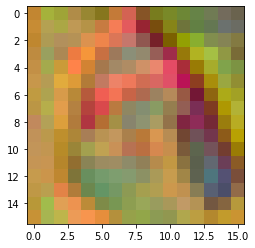

In [25]:
batch_norm = (batch_reduced - np.min(batch_reduced)) / (np.max(batch_reduced) - np.min(batch_reduced))
plt.imshow(batch_norm) 

# Visualization of SA Output

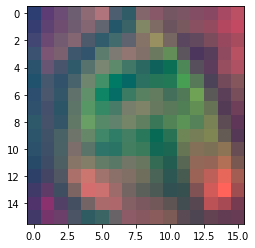

In [26]:
csam_norm = (csam_reduced - np.min(csam_reduced)) / (np.max(csam_reduced) - np.min(csam_reduced))
plt.imshow(csam_norm)

# Visualization of SA attention layer 

10


<AxesSubplot:>

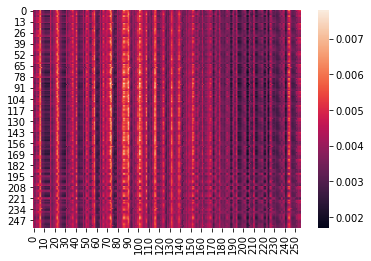

In [56]:
print(idx)
sns.heatmap(attn[idx].detach().cpu().numpy())

# Visualization of SA attention layer similarities 

<AxesSubplot:>

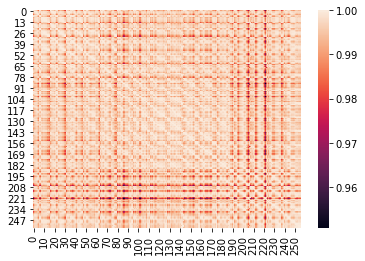

In [57]:
import sklearn

sim = sklearn.metrics.pairwise.cosine_similarity(attn[idx].detach().cpu().numpy())
sns.heatmap(sim)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


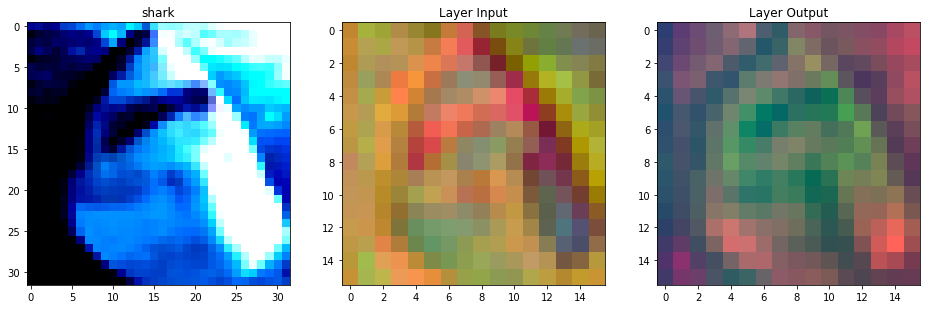

In [58]:
f, axarr = plt.subplots(1,3, figsize=(16,9))
axarr[0].imshow(image)
axarr[0].title.set_text(f'{class_name}')
axarr[1].imshow(batch_norm)
axarr[1].title.set_text('Layer Input')
axarr[2].imshow(csam_norm)
axarr[2].title.set_text('Layer Output')
# axarr[0, 4].imshow(image_datas[3])
f.show()

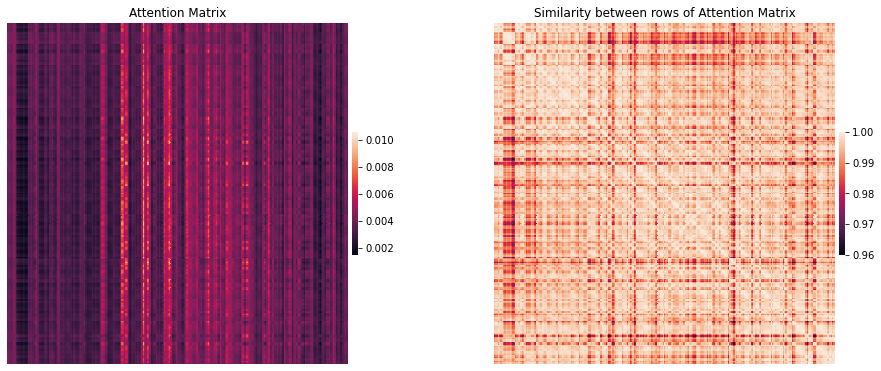

In [50]:
f, axarr = plt.subplots(1,2, figsize=(16,9))
sns.heatmap(attn[idx].detach().cpu().numpy(), ax=axarr[0],
           cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
           )
axarr[0].set_box_aspect(1)
axarr[0].title.set_text('Attention Matrix')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

sns.heatmap(sim, ax=axarr[1],
           cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
           )
axarr[1].set_box_aspect(1)
axarr[1].title.set_text('Similarity between rows of Attention Matrix')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

f.show()

In [27]:
attn.shape

torch.Size([64, 256, 256])

In [ ]:
f, axarr = plt.subplots(16,16, figsize=(25,25))
attn_i = attn[idx].detach().cpu().numpy()
for i in range(16):
    for j in range(16):
        m = attn_i[i*j,:]
        m.resize(16,16)
        sns.heatmap(m, ax=axarr[i,j],
           cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
           )
        axarr[i,j].set_box_aspect(1)